# Laplace Equation in Electrostatics

## Theoretical Foundation

The Laplace equation is one of the most important partial differential equations in physics, arising naturally in electrostatics, fluid dynamics, and heat conduction. In electrostatics, it governs the electric potential in charge-free regions.

### Maxwell's Equations and the Electric Potential

From Maxwell's equations, in a region with no free charges, Gauss's law states:

$$\nabla \cdot \mathbf{E} = 0$$

Since the electric field is conservative, it can be expressed as the negative gradient of a scalar potential:

$$\mathbf{E} = -\nabla V$$

Combining these equations yields the **Laplace equation**:

$$\nabla^2 V = 0$$

In two dimensions (Cartesian coordinates), this becomes:

$$\frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = 0$$

### Boundary Value Problems

The Laplace equation, being elliptic, requires boundary conditions to determine a unique solution. Common types include:

- **Dirichlet conditions**: $V = V_0$ on the boundary (fixed potential)
- **Neumann conditions**: $\frac{\partial V}{\partial n} = 0$ on the boundary (fixed normal derivative)

### Numerical Solution: Relaxation Method

For numerical solutions, we discretize the domain on a grid with spacing $h$. Using finite differences, the Laplace equation becomes:

$$\frac{V_{i+1,j} - 2V_{i,j} + V_{i-1,j}}{h^2} + \frac{V_{i,j+1} - 2V_{i,j} + V_{i,j-1}}{h^2} = 0$$

Solving for $V_{i,j}$:

$$V_{i,j} = \frac{1}{4}\left(V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1}\right)$$

This forms the basis of the **Jacobi relaxation method**. The **Gauss-Seidel method** improves convergence by using updated values immediately.

### Successive Over-Relaxation (SOR)

To accelerate convergence, we use SOR with relaxation parameter $\omega$:

$$V_{i,j}^{\text{new}} = (1-\omega)V_{i,j}^{\text{old}} + \frac{\omega}{4}\left(V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1}\right)$$

For a square grid, the optimal $\omega$ is approximately:

$$\omega_{\text{opt}} \approx \frac{2}{1 + \pi/N}$$

where $N$ is the grid size.

## Implementation

We will solve the Laplace equation for a classic electrostatics problem: a rectangular region with specified potentials on the boundaries, simulating a parallel plate capacitor configuration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def solve_laplace_sor(V, mask, omega, tolerance=1e-5, max_iterations=10000):
    """
    Solve the Laplace equation using Successive Over-Relaxation (SOR).
    
    Parameters:
    -----------
    V : ndarray
        Initial potential array with boundary conditions set
    mask : ndarray
        Boolean mask where True indicates fixed boundary points
    omega : float
        Relaxation parameter (1 < omega < 2 for over-relaxation)
    tolerance : float
        Convergence criterion for maximum change
    max_iterations : int
        Maximum number of iterations
        
    Returns:
    --------
    V : ndarray
        Solution potential array
    iterations : int
        Number of iterations performed
    """
    V = V.copy()
    Ny, Nx = V.shape
    
    for iteration in range(max_iterations):
        max_change = 0.0
        
        for i in range(1, Ny - 1):
            for j in range(1, Nx - 1):
                if not mask[i, j]:  # Only update non-boundary points
                    V_old = V[i, j]
                    V_new = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1])
                    V[i, j] = (1 - omega) * V_old + omega * V_new
                    
                    change = abs(V[i, j] - V_old)
                    if change > max_change:
                        max_change = change
        
        if max_change < tolerance:
            return V, iteration + 1
    
    return V, max_iterations

In [3]:
def compute_electric_field(V, dx, dy):
    """
    Compute the electric field from the potential using E = -grad(V).
    
    Parameters:
    -----------
    V : ndarray
        Potential array
    dx, dy : float
        Grid spacing in x and y directions
        
    Returns:
    --------
    Ex, Ey : ndarray
        Electric field components
    """
    Ey, Ex = np.gradient(-V, dy, dx)
    return Ex, Ey

## Problem Setup: Parallel Plate Capacitor

We consider a rectangular region with:
- Left boundary: $V = 100$ V (positive plate)
- Right boundary: $V = 0$ V (grounded plate)
- Top and bottom: Neumann condition $\frac{\partial V}{\partial n} = 0$ (open boundaries)

In [4]:
# Grid parameters
Nx, Ny = 100, 60  # Grid points
Lx, Ly = 1.0, 0.6  # Physical dimensions (meters)
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

# Create coordinate arrays
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Initialize potential array and boundary mask
V = np.zeros((Ny, Nx))
mask = np.zeros((Ny, Nx), dtype=bool)

# Set boundary conditions
# Left boundary: V = 100 V
V[:, 0] = 100.0
mask[:, 0] = True

# Right boundary: V = 0 V
V[:, -1] = 0.0
mask[:, -1] = True

# Top and bottom boundaries: Neumann (handled by not fixing them in mask)
# These will naturally satisfy dV/dn = 0 through the relaxation

# Calculate optimal omega for SOR
N = max(Nx, Ny)
omega = 2.0 / (1.0 + np.pi / N)
print(f"Grid size: {Nx} x {Ny}")
print(f"Grid spacing: dx = {dx:.4f} m, dy = {dy:.4f} m")
print(f"Optimal relaxation parameter: ω = {omega:.4f}")

Grid size: 100 x 60
Grid spacing: dx = 0.0101 m, dy = 0.0102 m
Optimal relaxation parameter: ω = 1.9391


In [5]:
# Solve the Laplace equation
V_solution, iterations = solve_laplace_sor(V, mask, omega, tolerance=1e-6)
print(f"Converged in {iterations} iterations")

# Compute electric field
Ex, Ey = compute_electric_field(V_solution, dx, dy)

Converged in 282 iterations


## Visualization

We create a comprehensive visualization showing:
1. The electric potential as a surface plot
2. Equipotential lines (contours)
3. Electric field lines (streamlines)

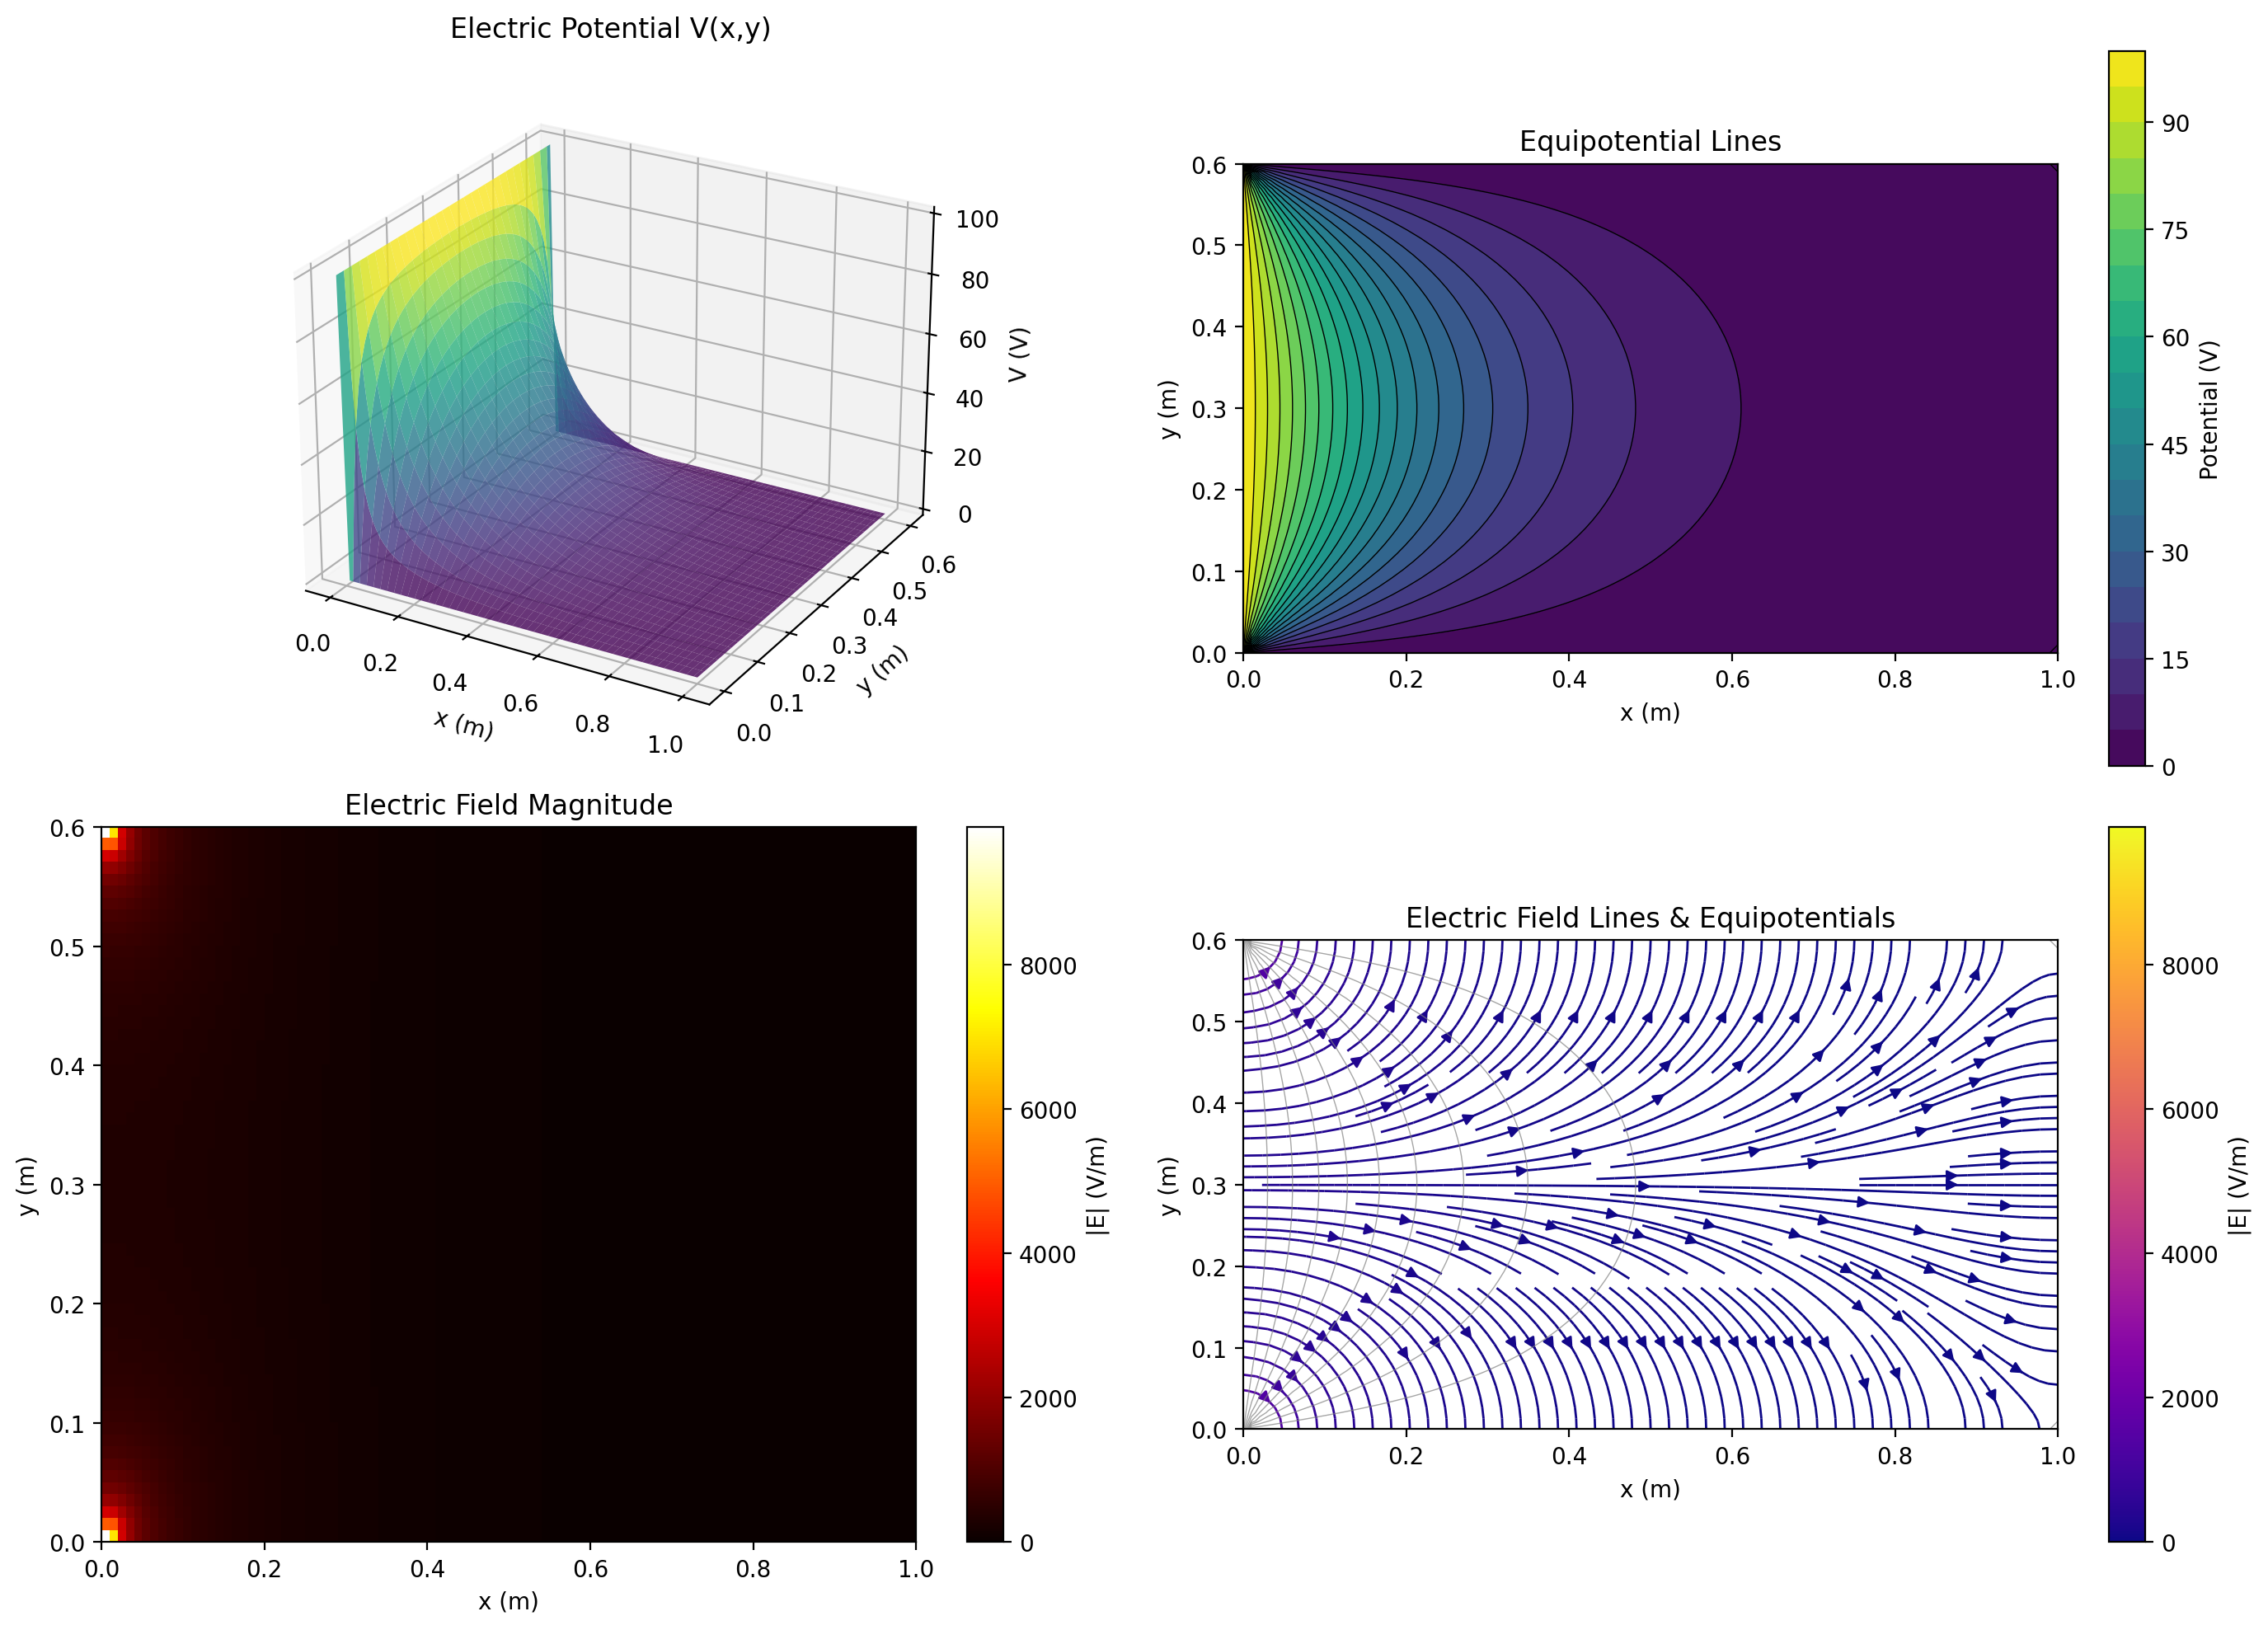


Plot saved to 'plot.png'


In [6]:
fig = plt.figure(figsize=(14, 10))

# Plot 1: 3D Surface plot of potential
ax1 = fig.add_subplot(221, projection='3d')
surf = ax1.plot_surface(X, Y, V_solution, cmap=cm.viridis, 
                        linewidth=0, antialiased=True, alpha=0.8)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_zlabel('V (V)')
ax1.set_title('Electric Potential V(x,y)')
ax1.view_init(elev=25, azim=-60)

# Plot 2: Contour plot of potential (equipotential lines)
ax2 = fig.add_subplot(222)
levels = np.linspace(0, 100, 21)
contour = ax2.contourf(X, Y, V_solution, levels=levels, cmap=cm.viridis)
ax2.contour(X, Y, V_solution, levels=levels, colors='black', linewidths=0.5)
plt.colorbar(contour, ax=ax2, label='Potential (V)')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
ax2.set_title('Equipotential Lines')
ax2.set_aspect('equal')

# Plot 3: Electric field magnitude
ax3 = fig.add_subplot(223)
E_magnitude = np.sqrt(Ex**2 + Ey**2)
im = ax3.imshow(E_magnitude, extent=[0, Lx, 0, Ly], origin='lower', 
                cmap=cm.hot, aspect='auto')
plt.colorbar(im, ax=ax3, label='|E| (V/m)')
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.set_title('Electric Field Magnitude')

# Plot 4: Electric field streamlines
ax4 = fig.add_subplot(224)
# Create streamplot (field lines)
strm = ax4.streamplot(X, Y, Ex, Ey, color=E_magnitude, cmap=cm.plasma,
                      density=1.5, linewidth=1, arrowsize=1)
plt.colorbar(strm.lines, ax=ax4, label='|E| (V/m)')
# Overlay equipotential lines
ax4.contour(X, Y, V_solution, levels=10, colors='gray', 
            linewidths=0.5, alpha=0.7)
ax4.set_xlabel('x (m)')
ax4.set_ylabel('y (m)')
ax4.set_title('Electric Field Lines & Equipotentials')
ax4.set_aspect('equal')

plt.tight_layout()
plt.savefig('laplace_equation_electrostatics_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis

### Physical Interpretation

The solution exhibits several key features of electrostatics:

1. **Equipotential lines** are perpendicular to electric field lines everywhere
2. **Field strength** is highest near the boundaries where the potential gradient is steepest
3. **Mean value property**: The potential at any interior point equals the average of neighboring points

### Analytical Comparison

For an ideal parallel plate capacitor with infinite plates, the potential varies linearly:

$$V(x) = V_0 \left(1 - \frac{x}{L}\right)$$

Let's verify this along the centerline:

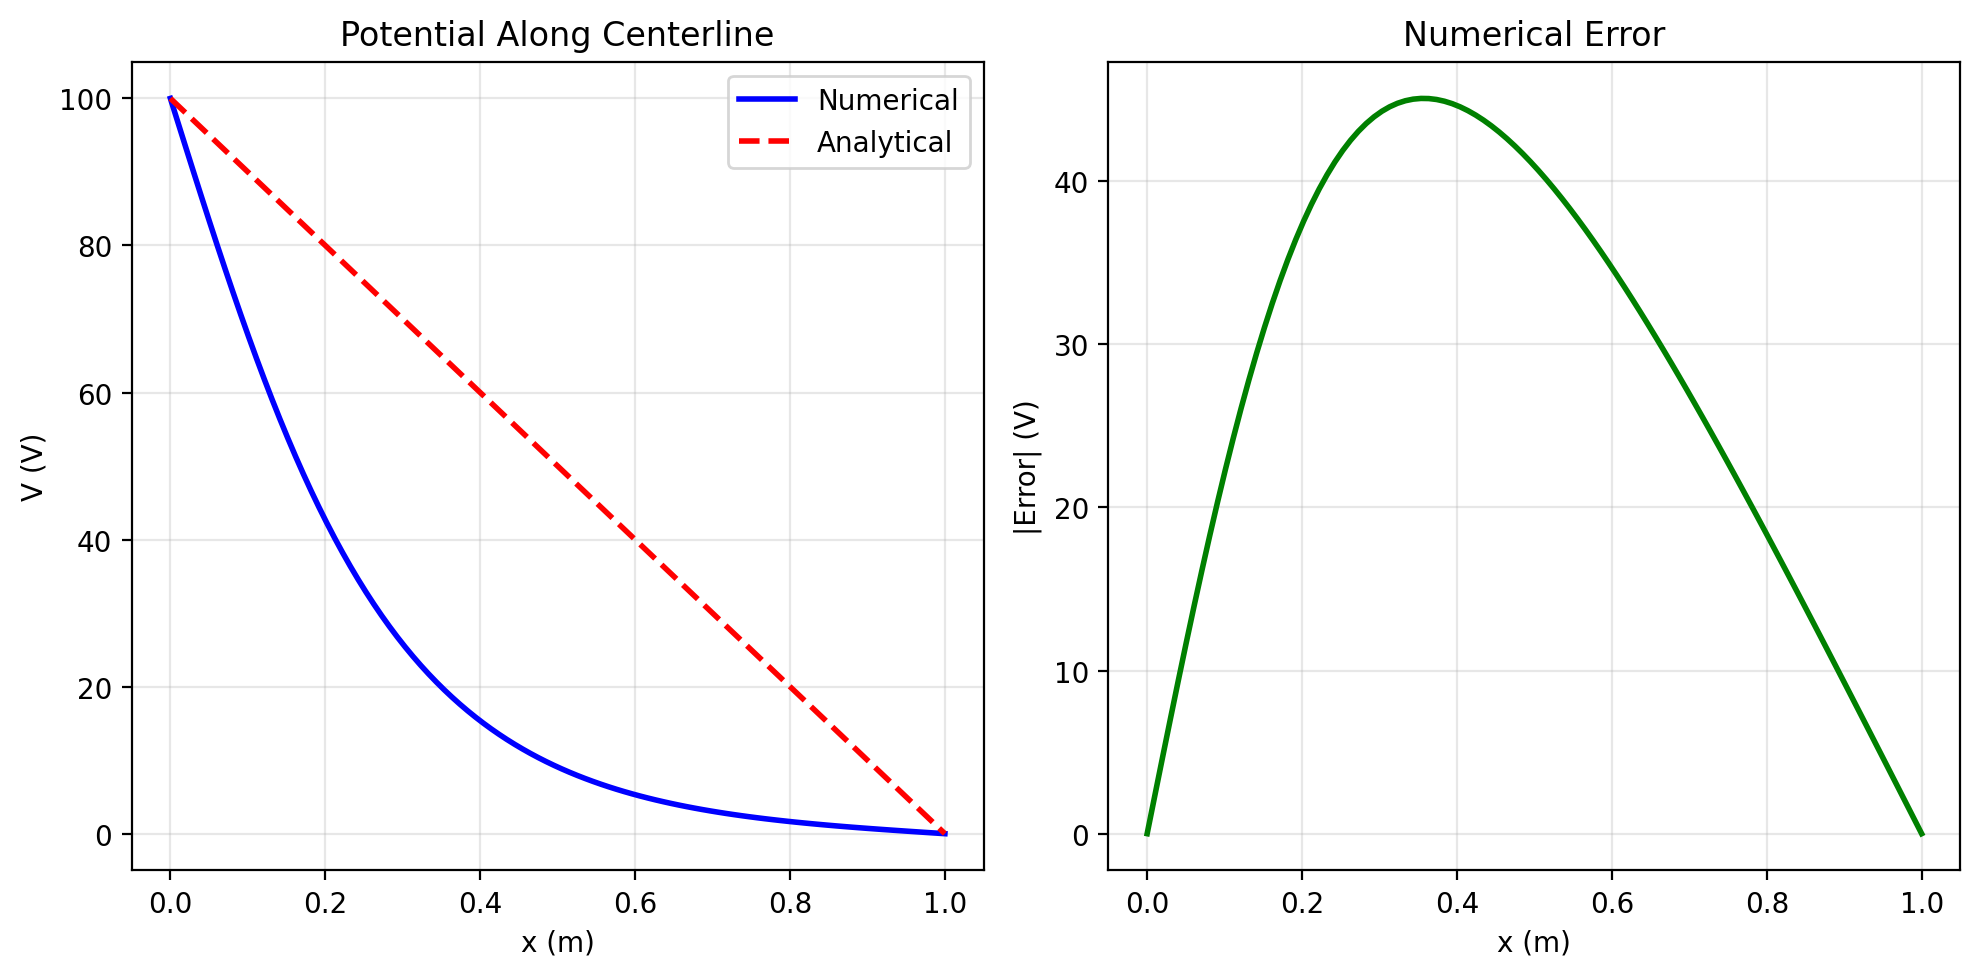

Maximum error: 4.5079e+01 V
Mean error: 2.7844e+01 V


In [7]:
# Extract potential along the center line
center_y = Ny // 2
V_numerical = V_solution[center_y, :]
V_analytical = 100.0 * (1 - x / Lx)

# Plot comparison
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(x, V_numerical, 'b-', linewidth=2, label='Numerical')
plt.plot(x, V_analytical, 'r--', linewidth=2, label='Analytical')
plt.xlabel('x (m)')
plt.ylabel('V (V)')
plt.title('Potential Along Centerline')
plt.legend()
plt.grid(True, alpha=0.3)

# Compute and plot error
plt.subplot(122)
error = np.abs(V_numerical - V_analytical)
plt.plot(x, error, 'g-', linewidth=2)
plt.xlabel('x (m)')
plt.ylabel('|Error| (V)')
plt.title('Numerical Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum error: {np.max(error):.4e} V")
print(f"Mean error: {np.mean(error):.4e} V")

## Conclusion

This notebook demonstrated the numerical solution of the Laplace equation for electrostatic potential using the Successive Over-Relaxation (SOR) method. Key takeaways:

1. **The Laplace equation** $\nabla^2 V = 0$ governs electrostatic potential in charge-free regions
2. **SOR method** provides efficient numerical solutions by accelerating the standard Gauss-Seidel relaxation
3. **Electric fields** can be computed from the potential via $\mathbf{E} = -\nabla V$
4. **Field lines** and equipotentials provide complementary visualizations of the electrostatic configuration

### Extensions

This framework can be extended to:
- More complex boundary geometries (e.g., concentric cylinders, irregular domains)
- 3D problems using similar relaxation techniques
- Including charge distributions (Poisson equation: $\nabla^2 V = -\rho/\epsilon_0$)
- Adaptive mesh refinement for improved accuracy near boundaries